<a href="https://colab.research.google.com/github/venezianof/booksum/blob/main/notebooks/Oumi%20-%20Training%20CNN%20on%20Custom%20Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="align-center">
<a href="https://oumi.ai/"><img src="https://oumi.ai/docs/en/latest/_static/logo/header_logo.png" height="200"></a>

[![Documentation](https://img.shields.io/badge/Documentation-latest-blue.svg)](https://oumi.ai/docs/en/latest/index.html)
[![Discord](https://img.shields.io/discord/1286348126797430814?label=Discord)](https://discord.gg/oumi)
[![GitHub Repo stars](https://img.shields.io/github/stars/oumi-ai/oumi)](https://github.com/oumi-ai/oumi)
<a target="_blank" href="https://colab.research.google.com/github/oumi-ai/oumi/blob/main/notebooks/Oumi - Training CNN on Custom Dataset.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</div>

👋 Welcome to Open Universal Machine Intelligence (Oumi)!

🚀 Oumi is a fully open-source platform that streamlines the entire lifecycle of foundation models - from [data preparation](https://oumi.ai/docs/en/latest/resources/datasets/datasets.html) and [training](https://oumi.ai/docs/en/latest/user_guides/train/train.html) to [evaluation](https://oumi.ai/docs/en/latest/user_guides/evaluate/evaluate.html) and [deployment](https://oumi.ai/docs/en/latest/user_guides/launch/launch.html). Whether you're developing on a laptop, launching large scale experiments on a cluster, or deploying models in production, Oumi provides the tools and workflows you need.

🤝 Make sure to join our [Discord community](https://discord.gg/oumi) to get help, share your experiences, and contribute to the project! If you are interested in joining one of the community's open-science efforts, check out our [open collaboration](https://oumi.ai/community) page.

⭐ If you like Oumi and you would like to support it, please give it a star on [GitHub](https://github.com/oumi-ai/oumi).

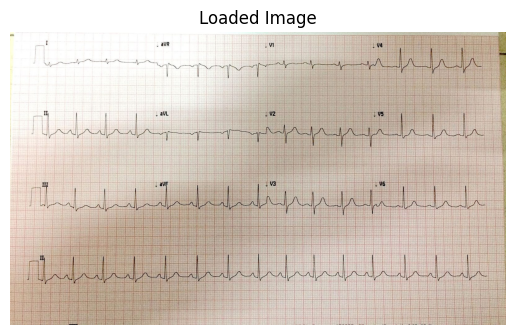

Image format: JPEG
Image mode: RGB
Image size (width, height): (1600, 946)


In [3]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/S3_912d3ec119bd4670b03643a4edd6590c.jpg'

try:
    # Load the image
    img = Image.open(image_path)

    # Display the image
    plt.imshow(img)
    plt.title('Loaded Image')
    plt.axis('off') # Hide axes
    plt.show()

    # Print image analysis (e.g., dimensions, format)
    print(f"Image format: {img.format}")
    print(f"Image mode: {img.mode}")
    print(f"Image size (width, height): {img.size}")

except FileNotFoundError:
    print(f"Error: The file '{image_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

```python
import numpy as np
import pandas as pd
from typing_extensions import override

from oumi.core.datasets import BaseMapDataset
from oumi.core.registry import register_dataset


@register_dataset("npz_file")
class NpzDataset(BaseMapDataset):
    """Loads dataset from Numpy .npz archive."""

    default_dataset = "custom"

    def __init__(
        self,
        *,
        dataset_name: str | None = None,
        dataset_path: str | Path | None = None,
        split: str | None = None,
        npz_split_col: str | None = None,
        npz_allow_pickle: bool = False,
        **kwargs,
    ) -> None:
        """Initializes a new instance of the NpzDataset class.

        Args:
            dataset_name: Dataset name.
            dataset_path: Path to .npz file.
            split: Dataset split.
            npz_split_col: Name of '.npz' array containing dataset split info.
                If unspecified, then the name "split" is assumed by default.
            npz_allow_pickle: Whether pickle is allowed when loading data
                from the npz archive.
            **kwargs: Additional arguments to pass to the parent class.

        Raises:
            ValueError: If dataset_path is not provided, or
                if .npz file contains data in unexpected format.
        """
        if not dataset_path:
            raise ValueError("`dataset_path` must be provided")
        super().__init__(
            dataset_name=dataset_name,
            dataset_path=(str(dataset_path) if dataset_path is not None else None),
            split=split,
            **kwargs,
        )
        self._npz_allow_pickle = npz_allow_pickle
        self._npz_split_col = npz_split_col

        dataset_path = Path(dataset_path)
        if not dataset_path.is_file():
            raise ValueError(f"Path is not a file! '{dataset_path}'")
        elif dataset_path.suffix.lower() != ".npz":
            raise ValueError(f"File extension is not '.npz'! '{dataset_path}'")

        self._data = self._load_data()

    @staticmethod
    def _to_list(x: np.ndarray) -> list:
        # `pd.DataFrame` expects Python lists for columns
        # (elements can still be `ndarray`)
        if len(x.shape) > 1:
            return [x[i, ...] for i in range(x.shape[0])]
        return x.tolist()

    @override
    def _load_data(self) -> pd.DataFrame:
        data_dict = {}
        if not self.dataset_path:
            raise ValueError("dataset_path is empty!")
        with np.load(self.dataset_path, allow_pickle=self._npz_allow_pickle) as npzfile:
            feature_names = list(sorted(npzfile.files))
            if len(feature_names) == 0:
                raise ValueError(
                    f"'.npz' archive contains no data! '{self.dataset_path}'"
                )
            num_examples = None
            for feature_name in feature_names:
                col_data = npzfile[feature_name]
                assert isinstance(col_data, np.ndarray)
                if num_examples is None:
                    num_examples = col_data.shape[0]
                elif num_examples != col_data.shape[0]:
                    raise ValueError(
                        "Inconsistent number of examples for features "
                        f"'{feature_name}' and '{feature_names[0]}': "
                        f"{col_data.shape[0]} vs {num_examples}!"
                    )
                data_dict[feature_name] = self._to_list(col_data)

        dataframe: pd.DataFrame = pd.DataFrame(data_dict)

        split_feature_name = (self._npz_split_col or "split") if self.split else None
        if split_feature_name:
            if split_feature_name not in dataframe:
                raise ValueError(
                    f"'.npz' doesn't contain data split info: '{split_feature_name}'!"
                )
            dataframe = pd.DataFrame(
                dataframe[dataframe[split_feature_name] == self.split].drop(
                    split_feature_name, axis=1
                ),
                copy=True,
            )
        return dataframe

    @override
    def transform(self, sample: pd.Series) -> dict:
        """Preprocesses the inputs in the given sample."""
        return sample.to_dict()
```

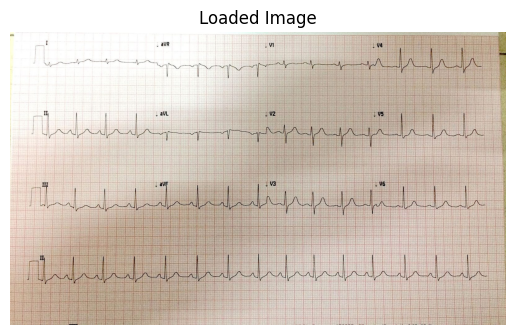

Image format: JPEG
Image mode: RGB
Image size (width, height): (1600, 946)


In [4]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/S3_912d3ec119bd4670b03643a4edd6590c.jpg'

try:
    # Load the image
    img = Image.open(image_path)

    # Display the image
    plt.imshow(img)
    plt.title('Loaded Image')
    plt.axis('off') # Hide axes
    plt.show()

    # Print image analysis (e.g., dimensions, format)
    print(f"Image format: {img.format}")
    print(f"Image mode: {img.mode}")
    print(f"Image size (width, height): {img.size}")

except FileNotFoundError:
    print(f"Error: The file '{image_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

# Training CNN on Custom Dataset

Oumi is not limited to LLMs. This example shows how to train a simple ConvNet classifier on a custom dataset containing binary data in Numpy `.npz` file. The dataset is created from the classic MNIST dataset (hand-written digits classification).

## 📋 Prerequisites

❗**NOTICE:** We recommend running this notebook on a GPU. If running on Google Colab, you can use the free T4 GPU runtime (Colab Menu: `Runtime` -> `Change runtime type`).

First, let's install Oumi. You can find more detailed instructions [here](https://oumi.ai/docs/en/latest/get_started/installation.html). Here, we include Oumi's GPU dependencies.


In [ ]:
%pip install oumi[gpu]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple ver

## Environment Setup: Common Imports and Variables

In [ ]:
import os
from pathlib import Path

import numpy as np
import torchvision

tutorial_dir = "cnn_mnist_tutorial"

Path(tutorial_dir).mkdir(parents=True, exist_ok=True)
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Disable warnings from HF

# Data
## Data Preparation
First, let's convert MNIST dataset to `.npz` archive.

In [ ]:
images = []
labels = []
splits = []
for train_split in (False, True):
    mnist_dataset = torchvision.datasets.MNIST(
        root=Path("/tmp/mnist_data"),
        train=train_split,
        download=True,
    )
    num_examples = len(mnist_dataset)
    images.extend(
        [np.asarray(mnist_dataset.data[i], dtype=np.uint8) for i in range(num_examples)]
    )
    labels.extend([int(mnist_dataset.targets[i]) for i in range(num_examples)])
    splits.extend([("train" if train_split else "test")] * num_examples)

npz_filename = (Path(tutorial_dir) / "mnist.npz").absolute()

# Normalize and convert [N,W,H] to [N,C,W,H] by adding dummy C=1 (PyTorch convention).
images = np.expand_dims((np.stack(images).astype(dtype=np.float32) / 255.0), axis=1)
np.savez_compressed(
    npz_filename, images=images, labels=np.stack(labels), split=np.stack(splits)
)
print(f"Saved {len(labels)} examples to '{npz_filename}'!")

Let's define Oumi custom dataset that can load MNIST data from `.npz` archive. For more details, refer to: https://oumi.ai/docs/en/latest/resources/datasets/datasets.html

In [ ]:
import numpy as np
import pandas as pd
from typing_extensions import override

from oumi.core.datasets import BaseMapDataset
from oumi.core.registry import register_dataset


@register_dataset("npz_file")
class NpzDataset(BaseMapDataset):
    """Loads dataset from Numpy .npz archive."""

    default_dataset = "custom"

    def __init__(
        self,
        *,
        dataset_name: str | None = None,
        dataset_path: str | Path | None = None,
        split: str | None = None,
        npz_split_col: str | None = None,
        npz_allow_pickle: bool = False,
        **kwargs,
    ) -> None:
        """Initializes a new instance of the NpzDataset class.

        Args:
            dataset_name: Dataset name.
            dataset_path: Path to .npz file.
            split: Dataset split.
            npz_split_col: Name of '.npz' array containing dataset split info.
                If unspecified, then the name "split" is assumed by default.
            npz_allow_pickle: Whether pickle is allowed when loading data
                from the npz archive.
            **kwargs: Additional arguments to pass to the parent class.

        Raises:
            ValueError: If dataset_path is not provided, or
                if .npz file contains data in unexpected format.
        """
        if not dataset_path:
            raise ValueError("`dataset_path` must be provided")
        super().__init__(
            dataset_name=dataset_name,
            dataset_path=(str(dataset_path) if dataset_path is not None else None),
            split=split,
            **kwargs,
        )
        self._npz_allow_pickle = npz_allow_pickle
        self._npz_split_col = npz_split_col

        dataset_path = Path(dataset_path)
        if not dataset_path.is_file():
            raise ValueError(f"Path is not a file! '{dataset_path}'")
        elif dataset_path.suffix.lower() != ".npz":
            raise ValueError(f"File extension is not '.npz'! '{dataset_path}'")

        self._data = self._load_data()

    @staticmethod
    def _to_list(x: np.ndarray) -> list:
        # `pd.DataFrame` expects Python lists for columns
        # (elements can still be `ndarray`)
        if len(x.shape) > 1:
            return [x[i, ...] for i in range(x.shape[0])]
        return x.tolist()

    @override
    def _load_data(self) -> pd.DataFrame:
        data_dict = {}
        if not self.dataset_path:
            raise ValueError("dataset_path is empty!")
        with np.load(self.dataset_path, allow_pickle=self._npz_allow_pickle) as npzfile:
            feature_names = list(sorted(npzfile.files))
            if len(feature_names) == 0:
                raise ValueError(
                    f"'.npz' archive contains no data! '{self.dataset_path}'"
                )
            num_examples = None
            for feature_name in feature_names:
                col_data = npzfile[feature_name]
                assert isinstance(col_data, np.ndarray)
                if num_examples is None:
                    num_examples = col_data.shape[0]
                elif num_examples != col_data.shape[0]:
                    raise ValueError(
                        "Inconsistent number of examples for features "
                        f"'{feature_name}' and '{feature_names[0]}': "
                        f"{col_data.shape[0]} vs {num_examples}!"
                    )
                data_dict[feature_name] = self._to_list(col_data)

        dataframe: pd.DataFrame = pd.DataFrame(data_dict)

        split_feature_name = (self._npz_split_col or "split") if self.split else None
        if split_feature_name:
            if split_feature_name not in dataframe:
                raise ValueError(
                    f"'.npz' doesn't contain data split info: '{split_feature_name}'!"
                )
            dataframe = pd.DataFrame(
                dataframe[dataframe[split_feature_name] == self.split].drop(
                    split_feature_name, axis=1
                ),
                copy=True,
            )
        return dataframe

    @override
    def transform(self, sample: pd.Series) -> dict:
        """Preprocesses the inputs in the given sample."""
        return sample.to_dict()

# Training a Model

Oumi provides the sample `CnnClassfier` model [[source](https://github.com/oumi-ai/oumi/blob/main/src/oumi/models/cnn_classifier.py)]. Let's use it to train a classifier for MNIST hand-written digits.

Oumi uses [training configuration files](https://oumi.ai/docs/en/latest/api/oumi.core.configs.html#oumi.core.configs.TrainingConfig) to specify training parameters. We've already created a training config for `CnnClassfier`--let's give it a try!

In [ ]:
yaml_content = f"""
model:
  model_name: "CnnClassifier"
  torch_dtype_str: "float32"
  load_pretrained_weights: False
  model_kwargs:
      image_width: 28   # MNIST images are 28x28 single channel
      image_height: 28
      in_channels: 1
      output_dim: 10    # Number of output classes: 10 digits

data:
  train:
    use_torchdata: True
    datasets:
      - dataset_name: "npz_file" # Custom dataset defined above for .npz archives
        dataset_path: "{npz_filename}"
        split: "train"

training:
  trainer_type: "OUMI"  # For non-transformers, use "OUMI" trainer
  per_device_train_batch_size: 64
  max_steps: 2000
  logging_steps: 500
  run_name: "mnist_cnn_classifier"
  output_dir: "{tutorial_dir}/output"
"""

with open(f"{tutorial_dir}/train.yaml", "w") as f:
    f.write(yaml_content)

In [ ]:
from oumi.core.configs import TrainingConfig
from oumi.train import train

config = TrainingConfig.from_yaml(str(Path(tutorial_dir) / "train.yaml"))

train(config)

# 🧭 What's Next?

Congratulations, you've trained your first CNN using data from a custom dataset (`numpy` arrays) with Oumi! Feel free to check out our other [notebooks](https://github.com/oumi-ai/oumi/tree/main/notebooks) in the [Oumi GitHub](https://github.com/oumi-ai/oumi), and give us a star! You can also join the Oumi community over on [Discord](https://discord.gg/oumi).

📰 Want to keep up with news from Oumi? Subscribe to our [Substack](https://blog.oumi.ai/) and [Youtube](https://www.youtube.com/@Oumi_AI)!

⚡ Interested in building custom AI in hours, not months? Apply to get [early access](https://oumi-ai.typeform.com/early-access) to the Oumi Platform, or [chat with us](https://calendly.com/d/ctcx-nps-47m/chat-with-us-get-early-access-to-the-oumi-platform) to learn more!